In [1]:
# load timecorr
import timecorr as tc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.spatial.distance import cdist
%matplotlib inline


In [2]:
def create_cov(cov, K):

    if cov is 'eye':
        R = np.eye(K)
    elif cov is 'toeplitz':
        R = scipy.linalg.toeplitz(np.linspace(0, 1, K)[::-1])
    elif cov is 'random':
        R = datasets.make_spd_matrix(K, random_state=1)
        R -= np.min(R)
        R /= np.max(R)
    elif isinstance(cov, np.ndarray):
        R = cov
    return R

In [3]:
def toeplitz_dataset(K, T, *args):

    corrs = np.zeros([T, int((K ** 2 - K) / 2 + K)])
    Y = np.zeros([T, K])

    for t in np.arange(T):
        corrs[t, :] = tc.mat2vec(create_cov('toeplitz', K))
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))

    return Y, corrs


In [4]:
def recovery_corrs(truth, guess):

    return np.diag(1 - cdist(truth[:, K:], guess[:, K:], 'correlation'))

In [5]:
def kron_time(mat_corr1, mat_corr2, T, K, kroned=True):
    """
    two KxKxT matrices
    """
    Y = np.zeros([T, K])
    truth_k = np.zeros([T, int((K ** 2 - K) / 2 + K)])
    
    for t in np.arange(T):

        if kroned:
            k = np.kron(mat_corr1[:, :, t], mat_corr2[:, :, t])
            #k = np.abs(k)
            
        else:
            k = np.dot(np.atleast_2d(mat_corr1[:, :, t].ravel()).T, np.atleast_2d(mat_corr1[:, :, t].ravel()))
            
        k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))
        
        k2 = np.abs(k2)
        
        ks = (k2 + k2.T)
        ks /= np.max(np.abs(ks))
        np.fill_diagonal(ks, 1.)

        truth_k[t, :] = tc.mat2vec(ks)
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(truth_k[t, :]))

    return Y, truth_k

In [6]:
T = 100
K =8


In [7]:
data1, toe_corr1 = toeplitz_dataset(K, T)
data2, toe_corr2 = toeplitz_dataset(K, T)
data3, toe_corr3 = toeplitz_dataset(K, T)
data4, toe_corr4 = toeplitz_dataset(K, T)

In [8]:
mat_toe_corr_1 = tc.vec2mat(toe_corr1)
mat_toe_corr_2 = tc.vec2mat(toe_corr2)
mat_toe_corr_3 = tc.vec2mat(toe_corr3)
mat_toe_corr_4 = tc.vec2mat(toe_corr4)

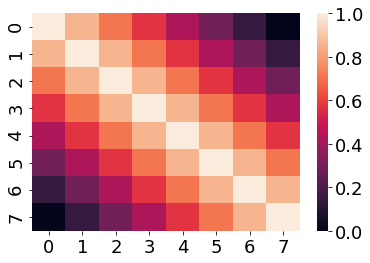

In [9]:
sns.heatmap(mat_toe_corr_1[:, :, 20])

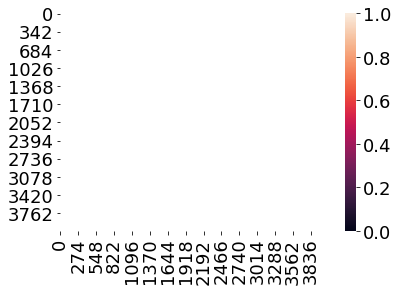

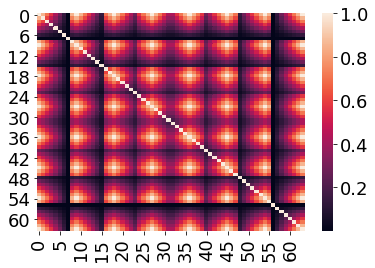

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.


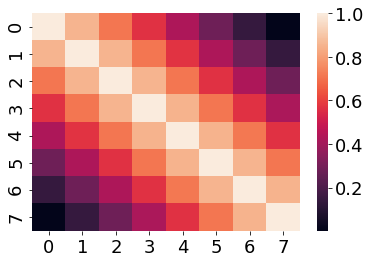

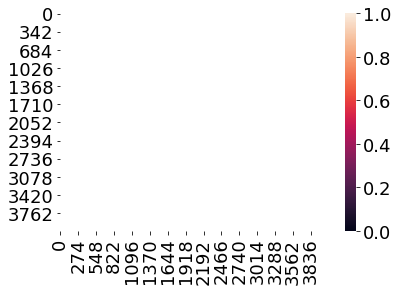

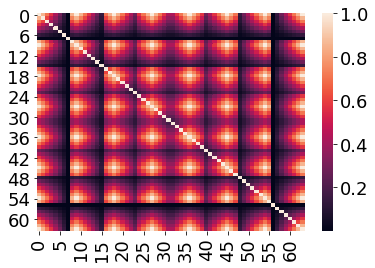

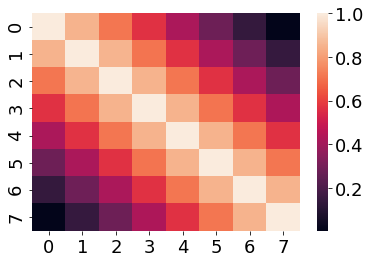

<Figure size 432x288 with 0 Axes>

In [10]:
for t in [30, 50]:
    
    k_1 = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, t].ravel()))
    k_2 = np.dot(np.atleast_2d(mat_toe_corr_3[:, :, t].ravel()).T, np.atleast_2d(mat_toe_corr_4[:, :, t].ravel()))
    
    k = np.dot(np.atleast_2d(k_1.ravel()).T, np.atleast_2d(k_2.ravel()))
    sns.heatmap(k)
    plt.show()
    plt.clf()
    k_mat_1 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K*K, K*K))
    
    k_t = np.abs(k_mat_1)
    k_mat = (k_t + k_t.T)
    k_mat /= np.max(np.abs(k_mat))
    np.fill_diagonal(k_mat, 1.)
    sns.heatmap(k_mat)
    plt.show()
    plt.clf()
    
    k_mat_2 = np.random.multivariate_normal(mean=np.zeros([k_mat_1.shape[0]]), cov=k_mat_1).reshape((K, K))
    k_t = np.abs(k_mat_2)
    k_mat = (k_t + k_t.T)
    k_mat /= np.max(np.abs(k_mat))
    np.fill_diagonal(k_mat, 1.)
    sns.heatmap(k_mat)
    plt.show()
    plt.clf()

In [11]:
# Y, truth_k = kron_time(mat_toe_corr_1, mat_toe_corr_2, T=T, K=K, kroned=True) ## this is crazy low
Y, truth_k = kron_time(mat_toe_corr_1, mat_toe_corr_2, T=T, K=K, kroned=False)

In [50]:
truth_k_mat = tc.vec2mat(truth_k)


In [51]:
second_order_vec = tc.timecorr(Y, weights_function=tc.gaussian_weights, weights_params={'var': 10})

In [52]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
corr_corr2.mean()

0.9908622363510282

In [53]:
second_order = tc.vec2mat(second_order_vec)

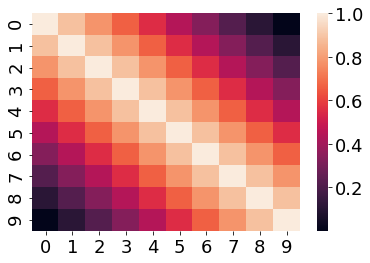

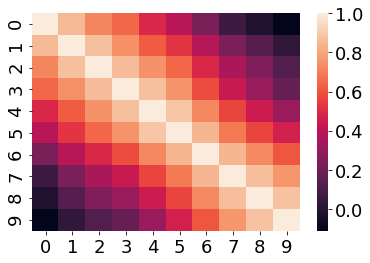

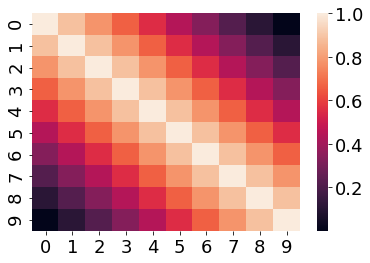

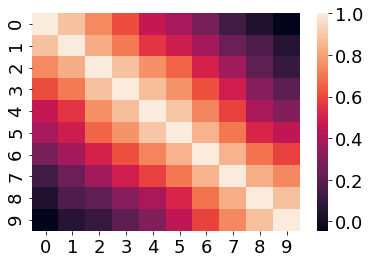

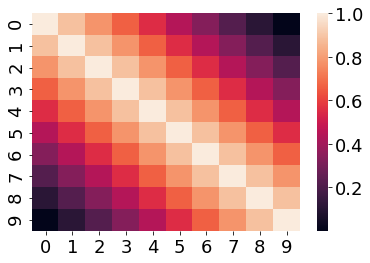

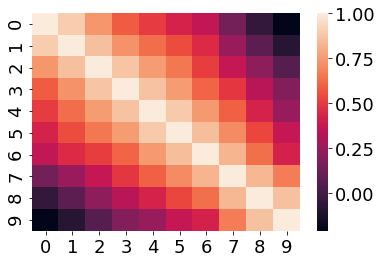

<Figure size 432x288 with 0 Axes>

In [54]:
for i in [20, 40, 100]:
    sns.heatmap(truth_k_mat[:, :, i])
    plt.show()
    plt.gcf()
    sns.heatmap(second_order[:, :, i])
    plt.show()
    plt.gcf()

In [55]:
k = np.kron(mat_toe_corr_1[:, :, 30], mat_toe_corr_2[:, :, 30])

k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))

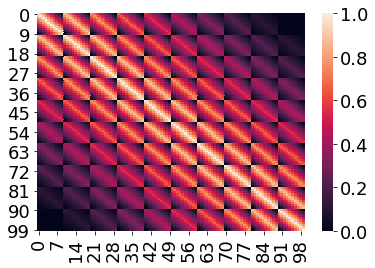

In [56]:
sns.heatmap(k)

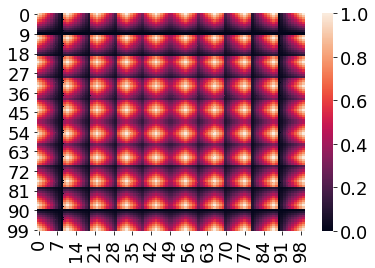

In [133]:
sns.heatmap(np.dot(np.atleast_2d(mat_toe_corr_1[:, :, 30].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, 30].ravel())))

In [149]:
k = np.dot(np.atleast_2d(mat_toe_corr_1[:, :, 40].ravel()).T, np.atleast_2d(mat_toe_corr_2[:, :, 40].ravel()))

In [150]:
k2 = np.random.multivariate_normal(mean=np.zeros([k.shape[0]]), cov=k).reshape((K, K))

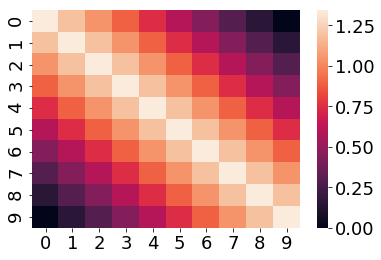

In [151]:
sns.heatmap(k2)

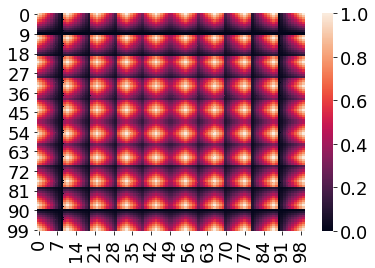

In [66]:
sns.heatmap(k)

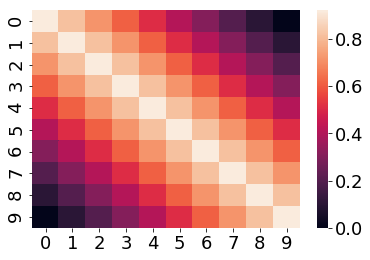

In [64]:
sns.heatmap(k2)

In [115]:
data1, corr1 = tc.simulate_data(datagen='ramping', return_corrs=True, set_random_seed=6, S=1, T=T, K=K)

data2, corr2  = tc.simulate_data(datagen='ramping', return_corrs=True, set_random_seed=5, S=1, T=T, K=K)

In [116]:

# convert from vector to matrix format
mat_corr_1 = tc.vec2mat(corr1)
mat_corr_2 = tc.vec2mat(corr2)

In [117]:
Y, truth_k = kron_time(mat_corr_1, mat_corr_2, T=T, K=K, kroned=False)

In [118]:
second_order_vec = tc.timecorr(Y, weights_function=tc.gaussian_weights, weights_params={'var': 10})

In [119]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [120]:
corr_corr2.mean()

0.6679000398173873

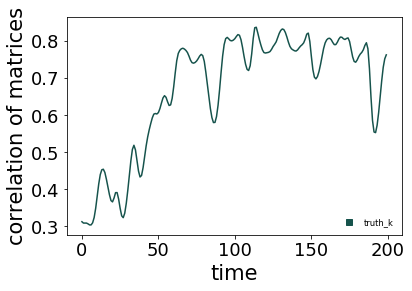

In [121]:
conditions = ['truth_k']
colors = sns.color_palette("cubehelix", 3)

for e, c in enumerate(conditions):

    plt.plot(np.diag(1 - cdist(np.atleast_2d(eval(c)[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
, color = colors[e])
    plt.xlabel('time')
    plt.ylabel('correlation of matrices')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
legend = plt.legend([f("s", colors[i]) for i in range(3)], conditions, loc=4, framealpha=1, frameon=False, fontsize = 'small')
plt.show()

In [122]:
second_order_vec = tc.timecorr(Y, weights_function=tc.eye_weights)

In [123]:
corr_corr2 = np.diag(1 - cdist(np.atleast_2d(truth_k[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))


In [124]:
corr_corr2.mean()

0.3401025581564602

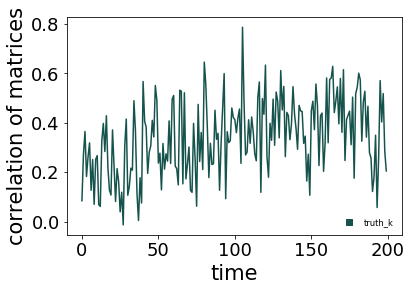

In [125]:
conditions = ['truth_k']
colors = sns.color_palette("cubehelix", 3)

for e, c in enumerate(conditions):

    plt.plot(np.diag(1 - cdist(np.atleast_2d(eval(c)[:, K:]), np.atleast_2d(second_order_vec[:, K:]), 'correlation'))
, color = colors[e])
    plt.xlabel('time')
    plt.ylabel('correlation of matrices')

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
legend = plt.legend([f("s", colors[i]) for i in range(3)], conditions, loc=4, framealpha=1, frameon=False, fontsize = 'small')
plt.show()